<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_CNN_BatchNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np
import random
import time
import os

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False

# CIFAR-10 데이터를 이용한다.

In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4), # Random Crop: Randomly crop the part of the large image and utilize it as an augmented data
        transforms.RandomHorizontalFlip(), # Random Horizontal Flip: Randomly flip the image and utilize it as an augmented data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]), # Normalize the data using the given mean and standard deviation
        ])

#Apply data preprocessing for test set
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

100%|██████████| 170498071/170498071 [00:03<00:00, 49657700.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


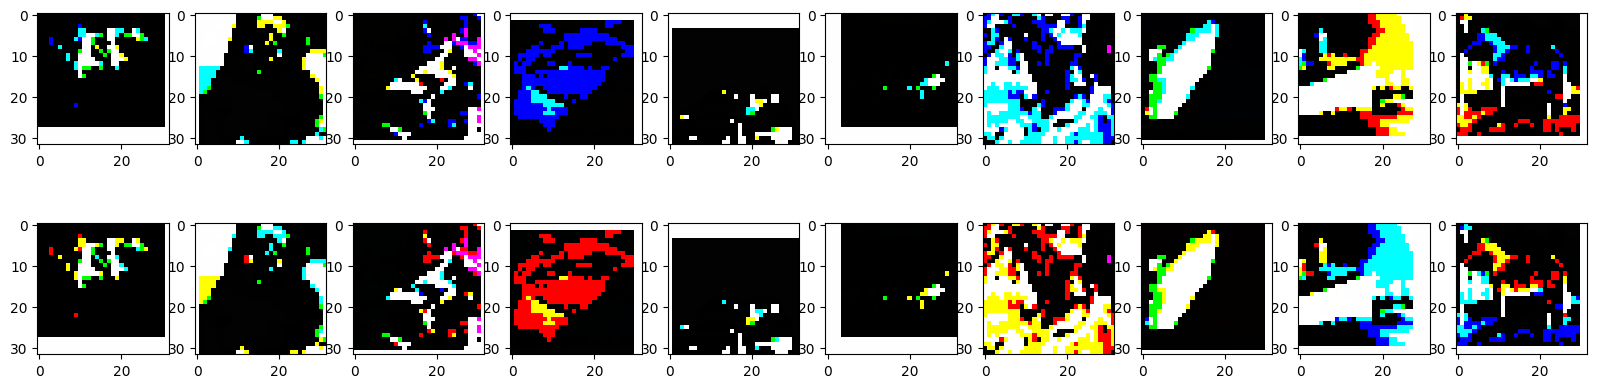

In [ ]:
# Cifar 데이터는 어떻게 생겼을까?
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

idxs = np.random.choice(len(train_dataset), 10, replace=False)

plt.figure(figsize=(20, 5))
for i, idx in enumerate(idxs):

  #### 실습 : Index로 데이터 확인
  #### 1) Tensor to Numpy 2) BGR to RGB
  image, target =  train_dataset[idx]

  image = image.permute(1,2,0).float().numpy()
  image_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #########################################

  plt.subplot(2, 10, i+1)
  plt.imshow(image.astype(np.uint8))
  plt.subplot(2, 10, i+11)
  plt.imshow(image_converted.astype(np.uint8))


In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# 학습함수를 선언하고 학습을 수행한다

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch):
  ### 실습 : 학습 중임을 알림
  model.train() ###
  for epoch in range(n_epoch):
    running_loss = 0
    for i, (images, labels) in enumerate(data_loader):
      ### 실습 : 데이터를 GPU로 할당
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (i + 1) % 100 == 0:
        print('iteration: [{}/{}]'.format(i + 1, len(data_loader)))

    print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
class VGG(nn.Module):
    def __init__(self):
      super(VGG, self).__init__()

      ##### 실습 : 위 그림에 있는 CNN구성 요소 선언
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # Convolutional layer with 3x3 kernel. The size of feature does not change due to the usage of padding.
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

      self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
      self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

      self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size
      self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) ## 실습: 이미지의 평균값을 계산하는 Layer
      self.fc = nn.Linear(in_features=128, out_features=10) # 실습 : 10개 Class를 만들어 내는 FC

    def forward(self, x):
      #### 실습 : VGG를 구성한다.
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.relu(x)
      x = self.conv4(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv5(x)
      x = F.relu(x)
      x = self.conv6(x)
      x = F.relu(x)   # 128x8x8
      x = self.avg_pool(x) # 128x1x1

      x = x.view(-1, 128)
      x = self.fc(x)
      return x

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
##### 실습 : 모델을 GPU에 할당한다.
vgg_model = VGG().to("cuda")

##### Adam 최적화 모델을 할당한다
optimizer = optim.Adam(params=vgg_model.parameters())

train(vgg_model, train_loader, criterion, optimizer, n_epoch=10)

iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 1, loss = 1.757
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 2, loss = 1.336
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 3, loss = 1.110
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 4, loss = 0.982
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 5, loss = 0.893
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 6, loss = 0.813
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 7, loss = 0.746
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 

# 평가 함수를 구성하고 평가 정확도를 확인한다

In [ ]:
def eval(model, data_loader):
  #### 실습 : 평가를 위해서는 eval()을 선언
  model.eval()
  total = 0
  correct = 0
  #### 실습 : Gradient를 타지 않아야 한다
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

  print('Test Accuracy: {}%'.format(accuracy))

In [ ]:
eval(vgg_model, test_loader)

Test Accuracy: 76.15%


# Batch Normalization을 구현한다

In [ ]:
class MyBatchNorm2d(nn.Module):
  def __init__(self, num_features, alpha=0.1):
    super(MyBatchNorm2d, self).__init__()

    ######### 실습 : 각 Channel에 대해 Scale & Shift할 인자를 정의한다
    self.gamma = nn.Parameter(torch.ones(num_features))
    self.beta = nn.Parameter(torch.ones(num_features))

    self.n_batches = 0
    self.alpha = alpha

  def forward(self, input):

    if self.training: # 'model.train()' 이 호출되면 자동으로 True로 세팅됨
      self.n_batches += 1
      ### 실습 : Channel이 차원 1에 있음. 나머지 영역에서 Mean/Var계산
      mean = input.mean([0, 2, 3], keepdim=True)
      var = input.var([0, 2, 3], keepdim=True)

      if self.n_batches == 1:
        ##### 실습 : 첫 Batch에는 평균/분산을 저장한다
        self.running_mean = mean
        self.running_var = var
      else:
        ##### 실습 : 평균, 분산에 대한 Moving Average를 계산한다
        self.running_mean = self.alpha * mean + (1 - self.alpha) * self.running_mean
        self.running_var = self.alpha * var + (1 - self.alpha) * self.running_var

    else: # 'model.eval()' 이 호출되면 자동으로 True로 세팅됨
      ##### 실습 : infernece 시에는 학습 시 저장한 값 활용
      mean = self.running_mean
      var = self.running_var

    #### 실습 : Standardization
    output = (input - mean) / (torch.sqrt(var + 1e-8))
    #### 실습 : 각 channel에 있는 값에 scale & shift 수행
    output = output * self.gamma.reshape(1, -1, 1, 1) + self.beta.reshape(1, -1, 1, 1)

    return output

# Barch Norm이 들어간 VGG를 구현한다

![](https://drive.google.com/uc?export=view&id=1vLrvhxczx1ZCOH05cxzzESylaOaF1Uj2)


In [ ]:
class VGG_BatchNorm(nn.Module):
  def __init__(self):
    super(VGG_BatchNorm, self).__init__()
    #### 실습 : BatchNormalization이 들어가 있는 구조 선언
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.norm1 = MyBatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.norm2 = MyBatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.norm3 = MyBatchNorm2d(64)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.norm4 = MyBatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.norm5 = MyBatchNorm2d(128)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.norm6 = MyBatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    #### 실습 : Batch Norm을 Convolution 이후에 선언
    x = self.norm1(self.conv1(x))
    x = F.relu(x)
    x = self.norm2(self.conv2(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm3(self.conv3(x))
    x = F.relu(x)
    x = self.norm4(self.conv4(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm5(self.conv5(x))
    x = F.relu(x)
    x = self.norm6(self.conv6(x))
    x = F.relu(x)

    x = self.avg_pool(x)
    x = x.view(-1, 128)
    x = self.fc(x)
    return x

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNorm().to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

train(vgg_batchnorm_model, train_loader, criterion, optimizer, n_epoch=10)

iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 1, loss = 1.471
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 2, loss = 1.128
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 3, loss = 0.985
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 4, loss = 0.874
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 5, loss = 0.802
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 6, loss = 0.747
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 7, loss = 0.701
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 

In [ ]:
eval(vgg_batchnorm_model, test_loader)

Test Accuracy: 72.84%


# Pytorch 의 BatchNorm2D를 이용

In [ ]:
class VGG_BatchNormTorch(nn.Module):
  def __init__(self):
    ### 실습 : 객체 이름과 초기화 이름은 똑같아야 한다
    super(VGG_BatchNormTorch, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm1 = torch.nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.norm2 = torch.nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm3 = torch.nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm4 = torch.nn.BatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm5 = torch.nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    #### 실습 : Batch Norm 을 Pytorch의 값으로 변경한다
    self.norm6 = torch.nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    #### 실습 : Batch Norm을 Convolution 이후에 선언
    x = self.norm1(self.conv1(x))
    x = F.relu(x)
    x = self.norm2(self.conv2(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm3(self.conv3(x))
    x = F.relu(x)
    x = self.norm4(self.conv4(x))
    x = F.relu(x)
    x = self.max_pool(x)

    x = self.norm5(self.conv5(x))
    x = F.relu(x)
    x = self.norm6(self.conv6(x))
    x = F.relu(x)

    x = self.avg_pool(x)
    x = x.view(-1, 128)
    x = self.fc(x)
    return x

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model_torch = VGG_BatchNormTorch().to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model_torch.parameters())

train(vgg_batchnorm_model_torch, train_loader, criterion, optimizer, n_epoch=10)

iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 1, loss = 1.307
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 2, loss = 0.907
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 3, loss = 0.761
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 4, loss = 0.667
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 5, loss = 0.605
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 6, loss = 0.561
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 7, loss = 0.524
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 

In [ ]:
eval(vgg_batchnorm_model_torch, test_loader)

Test Accuracy: 81.2%
